In [222]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import os
import time
import random
from sklearn.model_selection import train_test_split

In [2]:
os.chdir("data")
data = os.listdir()
os.chdir("..")

-0.6321983548023263

In [3]:
X_train = []
for path_img in data:
    img = cv2.imread("data/"+path_img)/255
    if img.shape != (64, 64, 3):
        print("Warning, wrong shape :",path_img)
    else:
        X_train.append(img)
X_train = np.array(X_train)
X_train.shape

(21551, 64, 64, 3)

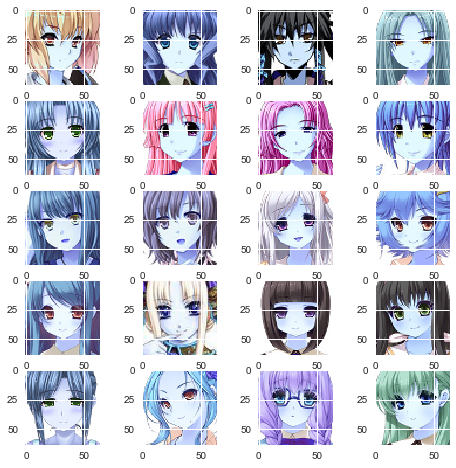

In [4]:
fig=plt.figure(figsize=(8, 8))
for i in range(1, 21):
    fig.add_subplot(5, 4, i)
    plt.imshow(X_train[i])
plt.show()

In [37]:
os.chdir("no_face/images")
no_face = os.listdir()
os.chdir("..")
os.chdir("..")
len(no_face)

In [211]:
def random_crop(img):
    max_allowed_size = np.min(img.shape[0:2])
    size = random.randint(WINDOW_SIZE, max_allowed_size)
    max_width = img.shape[0] - size - 1
    max_height = img.shape[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img[left:left+size,top:top+size]

def open_background(path: str):
    img = cv2.imread(path)
    img = random_crop(img)
    img = cv2.resize(img,(WINDOW_SIZE, WINDOW_SIZE))
    return img
WINDOW_SIZE=64

def data_generator(number):
    random_background_files=[]
    nb = number//len(no_face)
    for i in range(nb):
        random_background_files.extend(random.sample(no_face, len(no_face)))
        
    random_background_files.extend(random.sample(no_face, number-nb*len(no_face)))
    no_face_image=[]

    for img_path in random_background_files:
        no_face_image.append(open_background("no_face/images/"+img_path))
    return np.array(no_face_image)

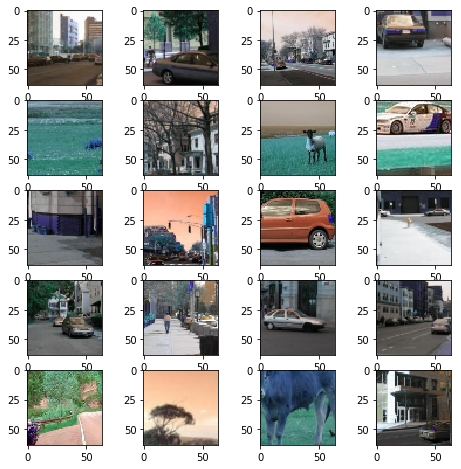

In [213]:
img_test = data_generator(20)
fig=plt.figure(figsize=(8, 8))
for i in range(0, 20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(img_test[i])
plt.show()

In [205]:
X_noface.shape

(715, 64, 64, 3)

In [223]:
X_noface=data_generator(len(X_train))
Y_noface=np.zeros(len(X_noface))
Y_train=np.ones(len(X_train))
X_train_f=np.concatenate([X_train,X_noface])
Y_train_f=np.concatenate([Y_train,Y_noface])
del X_noface
del Y_noface
del Y_train

X_tr,X_te,Y_tr,Y_te = train_test_split(X_train_f,Y_train_f,test_size=0.1)

del X_train_f
del Y_train_f

In [230]:
class Dataloader:
#     X_patch,Y_loc    
    def __init__(self,X,Y):
        self.currIdx=0
        self.X=X
        self.Y=Y

    def trainSet(self):
        self.currIdx = 0
#         random.shuffle(self.X)
        
    def hasNext(self,batch_size):
        return self.currIdx + batch_size <= len(self.X)
    
    def get_next(self,batch_size):
        batchRange = range(self.currIdx, self.currIdx + batch_size)
        self.currIdx += batch_size
        return [self.X[batchRange], self.Y[batchRange] ]          

In [232]:

def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

# Input features and output targets.
def generator(inputs, reuse=None):
    with tf.variable_scope("generator", reuse=reuse):
        c1_1=tf.layers.dense(inputs=inputs,units=192)
        c1_2=tf.reshape(c1_1,[-1,8,8,3])
    
        c2_1 = tf.layers.conv2d_transpose(inputs=c1_2,filters=512,kernel_size=(3,3),padding="same")
        c2_2 = tf.layers.conv2d_transpose(inputs=c2_1,filters=512,kernel_size=(3,3),strides=(2, 2),padding="same")
        c2_3 = tf.layers.batch_normalization(inputs=c2_2, trainable=True)
        c2_4 = tf.nn.leaky_relu(features=c2_3)
    
        c3_1 = tf.layers.conv2d_transpose(inputs=c2_4,filters=256,kernel_size=(3,3),padding="same")
        c3_2 = tf.layers.conv2d_transpose(inputs=c3_1,filters=256,kernel_size=(3,3),strides=(2, 2),padding="same")
        c3_3 = tf.layers.batch_normalization(inputs=c3_2, trainable=True)
        c3_4 = tf.nn.leaky_relu(features=c3_3)
    
        c4_1 = tf.layers.conv2d_transpose(inputs=c3_4,filters=128,kernel_size=(5,5),padding="same")
        c4_2 = tf.layers.conv2d_transpose(inputs=c4_1,filters=128,kernel_size=(5,5),padding="same")
        c4_3 = tf.layers.batch_normalization(inputs=c4_2, trainable=True)
        c4_4 = tf.nn.leaky_relu(features=c4_3)    

    
        c5_1 = tf.layers.conv2d_transpose(inputs=c4_4,filters=3,kernel_size=(5,5),strides=(2, 2),padding="same")
        c5_2 = tf.layers.conv2d_transpose(inputs=c5_1,filters=3,kernel_size=(5,5),padding="same")
        output = tf.nn.tanh(c5_2)
        return output
    
def discriminator(inputs, reuse=None):
    with tf.variable_scope("discriminator", reuse=reuse):
        c1_1 = tf.layers.conv2d(inputs=inputs,filters=32,kernel_size=(5,5),padding="same")
        c1_2 = tf.layers.conv2d(inputs=c1_1,filters=32,kernel_size=(5,5),padding="same")
        c1_3 = tf.layers.batch_normalization(inputs=c1_2, trainable=True)
        c1_4 = tf.nn.relu(features=c1_3)
        c1_5 = tf.layers.max_pooling2d(inputs=c1_4,pool_size=2,strides=2)
    
        c2_1 = tf.layers.conv2d(inputs=c1_5,filters=64,kernel_size=(5,5),padding="same")
        c2_2 = tf.layers.conv2d(inputs=c2_1,filters=64,kernel_size=(5,5),padding="same")
        c2_3 = tf.layers.batch_normalization(inputs=c2_2, trainable=True)
        c2_4 = tf.nn.relu(features=c2_3)
        c2_5 = tf.layers.max_pooling2d(inputs=c2_4,pool_size=2,strides=2)
    
        c3_1 = tf.layers.conv2d(inputs=c2_5,filters=128,kernel_size=(3,3),padding="same")
        c3_2 = tf.layers.conv2d(inputs=c3_1,filters=128,kernel_size=(3,3),padding="same")
        c3_3 = tf.layers.batch_normalization(inputs=c3_2, trainable=True)
        c3_4 = tf.nn.relu(features=c3_3)
        c3_5 = tf.layers.max_pooling2d(inputs=c3_4,pool_size=2,strides=2)
    
        c4_1 = tf.layers.conv2d(inputs=c3_5,filters=256,kernel_size=(3,3),padding="same")
        c4_2 = tf.layers.conv2d(inputs=c4_1,filters=256,kernel_size=(3,3),padding="same")
        c4_3 = tf.layers.batch_normalization(inputs=c4_2, trainable=True)
        c4_4 = tf.nn.relu(features=c4_3)
        c4_5 = tf.layers.max_pooling2d(inputs=c4_4,pool_size=2,strides=2)

        c5_1 = tf.reduce_mean(c4_5,reduction_indices=[1,2])
        c5_2 = tf.layers.dense(c5_1, 128)
        c5_3 = tf.layers.dense(c5_2, 64)
        c5_4 = tf.layers.dense(c5_3, 1)
        c5_5 = tf.nn.sigmoid(c5_4)
        return c5_5,c5_4

In [241]:
print(len(d_vars))
print(len(tvars))

30
30


In [244]:
tf.reset_default_graph()

real_images  = tf.placeholder(tf.float32,shape=[None,64,64,3])
targets = tf.placeholder(tf.float32,shape=[None,1])
D_output_real,D_logits_real=discriminator(real_images)

loss_classification = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,labels=targets))

learning_rate = tf.placeholder(tf.float32)
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'discriminator' in var.name]

D_class = tf.train.AdamOptimizer(learning_rate).minimize(loss_classification,var_list=d_vars)

In [255]:
Y_tr=Y_tr.reshape([-1,1])

In [258]:
loader.get_next(batch_size)[0].shape

(64, 64, 64, 3)

In [ ]:
saver = tf.train.Saver()

# loader = Dataloader(X_tr,Y_tr)
# epochs=10
# batch_size = 64
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    loader.trainSet()
    iteration = 0
    t0=time.time()
    while loader.hasNext(batch_size):
        iteration = iteration + 1
        batch_images = loader.get_next(batch_size)
        print("iteration :",iteration)
#         t1=time.time()
        sess.run(D_class,feed_dict={real_images:batch_images[0],targets:batch_images[1],learning_rate:0.001})
#         print("t1_1 :",time.time()-t1)
        if iteration%10==0:
            print("Loss",sess.run(loss_classification,feed_dict={real_images:batch_images[0],targets:batch_images[1]}))
            t0=time.time()
            if iteration%100==0:
                save_path = saver.save(sess, "./model_classification_"+str(epoch)+"_"+str(iteration)+".ckpt")
            

iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
Loss 0.095904976
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
Loss 0.08274658
iteration : 21
iteration : 22
iteration : 23
iteration : 24
iteration : 25
iteration : 26
iteration : 27
iteration : 28
iteration : 29
iteration : 30
Loss 0.0781684
iteration : 31
iteration : 32
iteration : 33
iteration : 34
iteration : 35
iteration : 36
iteration : 37
iteration : 38
iteration : 39
iteration : 40
Loss 0.069750026
iteration : 41
iteration : 42
iteration : 43
iteration : 44
iteration : 45
iteration : 46
iteration : 47
iteration : 48
iteration : 49
iteration : 50
Loss 0.060671262
iteration : 51
iteration : 52
iteration : 53
iteration : 54
iteration : 55
iteration : 56
iteration : 57
iteration : 58
iteration : 59
iteration : 60
Loss 0.05149376
iteration :

In [17]:
# tf.reset_default_graph()

noice = tf.placeholder(tf.float32,shape=[None,100])
# real_images  = tf.placeholder(tf.float32,shape=[None,64,64,3])

G=generator(noice)
# D_output_real,D_logits_real=discriminator(real_images)
D_output_fake,D_logits_fake=discriminator(G,reuse=True)

def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

D_real_loss=loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization
D_fake_loss=loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
D_loss=D_real_loss+D_fake_loss

G_loss= loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [18]:
learning_rate = tf.placeholder(tf.float32)
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'discriminator' in var.name]
g_vars=[var for var in tvars if 'generator' in var.name]

D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss,var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss,var_list=g_vars)

In [21]:
saver = tf.train.Saver()

loader = Dataloader(X_train)
epochs=10
batch_size = 64
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    loader.trainSet()
    iteration = 0
    t0=time.time()
    while loader.hasNext(batch_size):
        iteration = iteration + 1
        batch_images = loader.get_next(batch_size)
        batch_noice = np.random.uniform(-1,1,size=(batch_size,100))
        print("iteration :",iteration)
        t1=time.time()
        sess.run(D_trainer,feed_dict={real_images:batch_images,noice:batch_noice,learning_rate:0.001})
        print("t1_1 :",time.time()-t1)
        sess.run(G_trainer,feed_dict={noice:batch_noice,learning_rate:0.001})
        print("t1_2 :",time.time()-t1)
        if iteration%10==0:
            print("Iteration :",iteration,"Time for 10 iteration:",time.time()-t0)
            print("Loss",sess.run([G_loss,D_loss],feed_dict={real_images:batch_images,noice:batch_noice}))
            t0=time.time()
            if iteration%100==0:
                save_path = saver.save(sess, "./model_"+str(epoch)+"_"+str(iteration)+".ckpt")
            

iteration : 1
t1_1 : 17.771016359329224
t1_2 : 40.76033115386963
iteration : 2
t1_1 : 16.734957218170166
t1_2 : 40.91334009170532
iteration : 3
t1_1 : 17.99302911758423
t1_2 : 41.10735106468201
iteration : 4
t1_1 : 18.162038803100586
t1_2 : 43.66349744796753
iteration : 5
t1_1 : 18.808075666427612
t1_2 : 44.45754265785217
iteration : 6
t1_1 : 18.8400776386261
t1_2 : 44.67555522918701
iteration : 7
t1_1 : 18.491057634353638
t1_2 : 42.88545274734497
iteration : 8
t1_1 : 18.897080898284912
t1_2 : 45.27358961105347
iteration : 9
t1_1 : 19.845134973526


KeyboardInterrupt: 

In [35]:
saver = tf.train.Saver()
for epoch in range(10000000):
    loader.trainSet()
    iteration = 0
    t0=time.time()
    while loader.hasNext(batch_size):
        iteration = iteration + 1
        print("iteration :",iteration)
        batch_images = loader.get_next(batch_size)
        batch_noice = np.random.uniform(-1,1,size=(batch_size,100))
        sess.run(D_trainer,feed_dict={real_images:batch_images,noice:batch_noice,learning_rate:0.001})
        sess.run(G_trainer,feed_dict={noice:batch_noice,learning_rate:0.001})
        if iteration%10==0:
            print("Iteration :",iteration,"Time for 10 iteration:",time.time()-t0)
            print("Loss",sess.run([G_loss,D_loss],feed_dict={real_images:batch_images,noice:batch_noice}))
            t0=time.time()
            if iteration%100==0:
                save_path = saver.save(sess, "./model_"+str(epoch)+"_"+str(iteration)+".ckpt")

iteration : 1
iteration : 2
iteration : 3


KeyboardInterrupt: 

In [62]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./model_"+str(epoch)+"_"+str(iteration)+".ckpt")

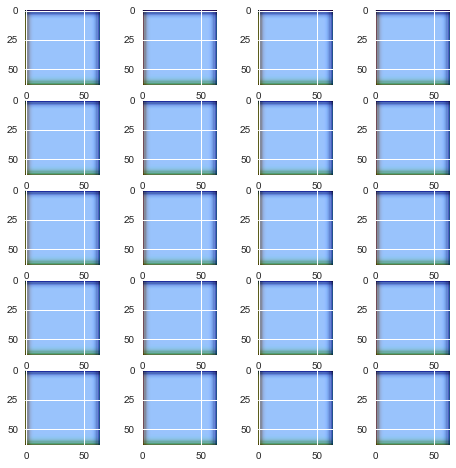

In [40]:
zzz = sess.run(G,feed_dict={noice:np.random.uniform(-1,1,size=(20,100))})
fig=plt.figure(figsize=(8, 8))
for i in range(0, 20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow((zzz[i]-np.min(zzz[i]))/np.max(zzz[i]-np.min(zzz[i])))
plt.show()

In [79]:
np.random.uniform(-1,1,size=(20,100))

array([[ 0.5612906 , -0.23144715,  0.27474986, ...,  0.51873839,
         0.27435406,  0.03196301],
       [ 0.84905844,  0.36510386,  0.94891323, ..., -0.37398959,
        -0.31748031, -0.41665927],
       [ 0.25542165, -0.13300681, -0.57182812, ..., -0.84994514,
        -0.3468773 , -0.32640471],
       ...,
       [-0.97948973, -0.59297336, -0.89684511, ..., -0.2287812 ,
         0.23361952, -0.52790137],
       [-0.4015087 , -0.34118969,  0.63688962, ..., -0.58315718,
         0.19888151, -0.28543957],
       [-0.45917474, -0.58233225, -0.50656524, ...,  0.53665939,
         0.44938626, -0.99016466]])

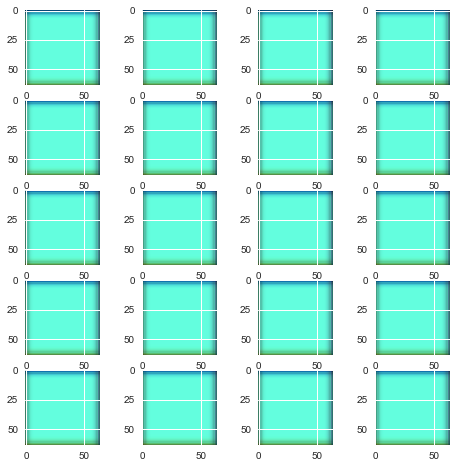

In [80]:
zzz = sess.run(G,feed_dict={noice:np.random.uniform(-1,1,size=(20,100))})
fig=plt.figure(figsize=(8, 8))
for i in range(0, 20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow((zzz[i]-np.min(zzz[i]))/np.max(zzz[i]-np.min(zzz[i])))
plt.show()

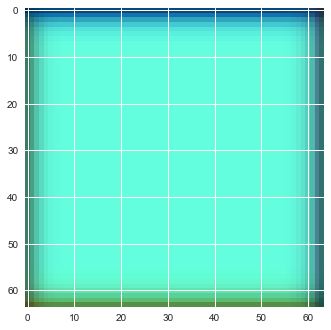

In [67]:
plt.imshow((zzz[i]-np.min(zzz[i]))/np.max(zzz[i]-np.min(zzz[i])))
plt.show()

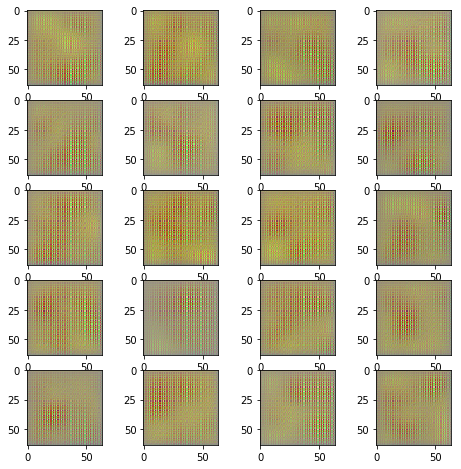

In [22]:
zzz = sess.run(G,feed_dict={noice:np.random.uniform(-1,1,size=(20,100))})
fig=plt.figure(figsize=(8, 8))
for i in range(0, 20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow((zzz[i]-np.min(zzz[i]))/np.max(zzz[i]-np.min(zzz[i])))
plt.show()

array([[[ 1.        ,  0.9999999 ,  1.        ],
        [ 0.99999344,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        ...,
        [ 0.32183975,  0.999884  ,  0.999968  ],
        [ 0.9999997 ,  0.99997324,  0.31602317],
        [-0.9508324 , -0.8010467 ,  0.89004904]],

       [[ 1.        , -0.67596596,  1.        ],
        [ 1.        ,  0.97912294,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        ...,
        [ 1.        ,  1.        ,  1.        ],
        [-0.9993723 ,  1.        ,  1.        ],
        [ 0.99999976,  1.        ,  1.        ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        ...,
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  0.9997681 ],
        [ 0.99999607,  0.9999991 ,  0.99491084]],

       ...,

       [[ 1.        ,  0.9988024 ,  1.        ],
        [ 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

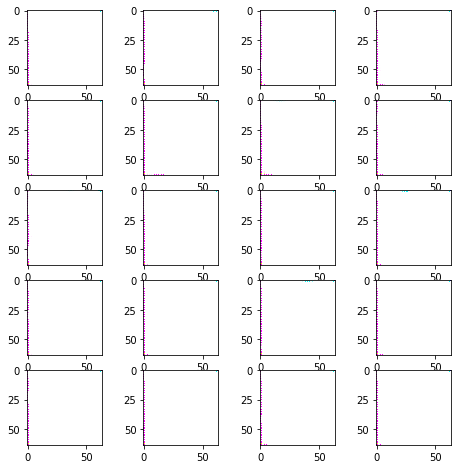

In [34]:
zzz = sess.run(G,feed_dict={noice:np.random.uniform(-1,1,size=(20,100))})
fig=plt.figure(figsize=(8, 8))
for i in range(0, 20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(zzz[i])
plt.show()

Iteration : 10 Time for 10 iteration: 173.21571326255798
Loss [0.80321133, 1.3721036]
Iteration : 20 Time for 10 iteration: 175.52858352661133
Loss [1.6554672, 1.7230028]
Iteration : 30 Time for 10 iteration: 177.82669043540955
Loss [0.9681291, 1.273256]
Iteration : 40 Time for 10 iteration: 171.85369658470154
Loss [0.73833585, 1.3785741]
Iteration : 50 Time for 10 iteration: 178.55481338500977
Loss [0.5316295, 1.5191327]
Iteration : 60 Time for 10 iteration: 171.03422498703003
Loss [0.7876248, 1.3316646]
Iteration : 70 Time for 10 iteration: 168.73843955993652
Loss [0.7865721, 0.9422566]
Iteration : 80 Time for 10 iteration: 168.45569944381714
Loss [0.9658647, 0.81836784]
Iteration : 90 Time for 10 iteration: 167.94425559043884
Loss [1.818962, 0.5924785]
Iteration : 100 Time for 10 iteration: 168.17102360725403
Loss [1.0045314, 0.9234039]
Iteration : 110 Time for 10 iteration: 170.75930285453796
Loss [1.3728055, 0.77426684]
Iteration : 120 Time for 10 iteration: 167.5896189212799
Loss [1.3789253, 1.876506]
Iteration : 130 Time for 10 iteration: 167.31490063667297
Loss [8.2182665, 0.6483628]
Iteration : 140 Time for 10 iteration: 167.4907193183899
Loss [1.003489, 1.4054954]
Iteration : 150 Time for 10 iteration: 169.22694492340088
Loss [0.87456506, 1.3741685]
Iteration : 160 Time for 10 iteration: 168.02589535713196
Loss [0.6388969, 1.3930893]
Iteration : 170 Time for 10 iteration: 168.18201160430908
Loss [1.8555554, 1.3650799]
Iteration : 180 Time for 10 iteration: 167.90490531921387
Loss [0.8975858, 1.3839496]
Iteration : 190 Time for 10 iteration: 167.77542877197266
Loss [0.81172425, 1.376437]
Iteration : 200 Time for 10 iteration: 167.8583436012268
Loss [0.78215456, 1.3765247]
Iteration : 210 Time for 10 iteration: 171.25714492797852
Loss [0.78359324, 1.3765073]
Iteration : 220 Time for 10 iteration: 168.63255143165588
Loss [0.7937651, 1.376296]
Iteration : 230 Time for 10 iteration: 168.1840102672577
Loss [0.80030113, 1.3762801]
Iteration : 240 Time for 10 iteration: 167.86533665657043
Loss [0.80147797, 1.3763769]
Iteration : 250 Time for 10 iteration: 167.99320697784424
Loss [0.8000055, 1.3762889]
Iteration : 260 Time for 10 iteration: 167.84323859214783
Loss [0.7985168, 1.3762776]
Iteration : 270 Time for 10 iteration: 167.55093121528625
Loss [0.7979953, 1.3764083]
Iteration : 280 Time for 10 iteration: 167.62158513069153
Loss [0.7981625, 1.3762779]
Iteration : 290 Time for 10 iteration: 167.79440832138062
Loss [0.7984571, 1.376281]
Iteration : 300 Time for 10 iteration: 167.43078064918518
Loss [0.79859596, 1.3762778]
Iteration : 310 Time for 10 iteration: 169.40640473365784
Loss [0.798583, 1.3763479]
Iteration : 320 Time for 10 iteration: 168.1750202178955
Loss [0.79852545, 1.3762776]
Iteration : 330 Time for 10 iteration: 167.74445962905884
Loss [0.79849285, 1.3762777]
Iteration : 10 Time for 10 iteration: 167.60733604431152
Loss [0.7984987, 1.3762777]
Iteration : 20 Time for 10 iteration: 167.87404799461365
Loss [0.7985073, 1.3762774]
Iteration : 30 Time for 10 iteration: 167.72847604751587
Loss [0.79850984, 1.3762774]
Iteration : 40 Time for 10 iteration: 168.0271716117859
Loss [0.79850876, 1.3762774]
Iteration : 50 Time for 10 iteration: 168.18900656700134
Loss [0.7985073, 1.3762774]
Iteration : 60 Time for 10 iteration: 168.20849537849426
Loss [0.7985063, 1.3762777]
Iteration : 70 Time for 10 iteration: 168.13306260108948
Loss [0.7985105, 1.3762774]
Iteration : 80 Time for 10 iteration: 167.7304744720459
Loss [0.7985115, 1.3763516]
Iteration : 90 Time for 10 iteration: 168.30488681793213
Loss [0.7985105, 1.3762987]
Iteration : 100 Time for 10 iteration: 168.66052389144897
Loss [0.7985079, 1.3762965]
Iteration : 110 Time for 10 iteration: 169.766672372818
Loss [0.79850584, 1.3762774]
Iteration : 120 Time for 10 iteration: 167.88132095336914
Loss [0.7985063, 1.3762777]
Iteration : 130 Time for 10 iteration: 167.552729845047
Loss [0.79850715, 1.3762774]
Iteration : 140 Time for 10 iteration: 168.08111596107483
Loss [0.7985079, 1.3762772]
Iteration : 150 Time for 10 iteration: 168.08611059188843
Loss [0.7985081, 1.3762774]
Iteration : 160 Time for 10 iteration: 167.9732255935669
Loss [0.7985068, 1.3762777]
Iteration : 170 Time for 10 iteration: 168.13406109809875
Loss [0.798506, 1.3762772]
Iteration : 180 Time for 10 iteration: 167.92066144943237
Loss [0.79850733, 1.3762777]
Iteration : 190 Time for 10 iteration: 167.95824146270752
Loss [0.7985064, 1.3762776]
Iteration : 200 Time for 10 iteration: 168.3398516178131
Loss [0.7985057, 1.3762777]
WARNING:tensorflow:From C:\Users\Thomas\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:966: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Iteration : 210 Time for 10 iteration: 170.08006834983826
Loss [0.7985049, 1.3762777]
Iteration : 220 Time for 10 iteration: 167.97122859954834
Loss [0.79850584, 1.3762777]
Iteration : 230 Time for 10 iteration: 167.99221420288086
Loss [0.7985067, 1.3762777]
Iteration : 240 Time for 10 iteration: 167.87033128738403
Loss [0.79850525, 1.3762776]
Iteration : 250 Time for 10 iteration: 167.8963122367859
Loss [0.79850584, 1.3762776]
Iteration : 260 Time for 10 iteration: 168.19399905204773
Loss [0.7985063, 1.3762774]
Iteration : 270 Time for 10 iteration: 167.74822306632996
Loss [0.7985053, 1.3762758]
Iteration : 280 Time for 10 iteration: 168.2369565963745
Loss [0.79850346, 1.3762776]
Iteration : 290 Time for 10 iteration: 167.87133049964905
Loss [0.79850376, 1.3762777]
Iteration : 300 Time for 10 iteration: 169.2466959953308
Loss [0.7985068, 1.3762776]
Iteration : 310 Time for 10 iteration: 170.018700838089
Loss [0.7985084, 1.3762777]
Iteration : 320 Time for 10 iteration: 167.51269674301147
Loss [0.7985062, 1.3762951]
Iteration : 330 Time for 10 iteration: 167.30690789222717
Loss [0.7985048, 1.3762776]
Iteration : 10 Time for 10 iteration: 168.53065514564514
Loss [0.79850775, 1.3762777]
Iteration : 20 Time for 10 iteration: 166.9193024635315
Loss [0.7985083, 1.3762777]
Iteration : 30 Time for 10 iteration: 167.67852687835693
Loss [0.7985081, 1.3762776]
Iteration : 40 Time for 10 iteration: 167.37700986862183
Loss [0.7985078, 1.3762777]
Iteration : 50 Time for 10 iteration: 167.3348789215088
Loss [0.79850763, 1.3762777]
Iteration : 60 Time for 10 iteration: 167.47573447227478
Loss [0.7985073, 1.3762777]
Iteration : 70 Time for 10 iteration: 167.44976091384888
Loss [0.79850715, 1.3762776]
Iteration : 80 Time for 10 iteration: 168.08320999145508
Loss [0.79850733, 1.3762776]
Iteration : 90 Time for 10 iteration: 167.72508454322815
Loss [0.79850775, 1.3762776]
Iteration : 100 Time for 10 iteration: 167.46374678611755
Loss [0.7985073, 1.3762777]
Iteration : 110 Time for 10 iteration: 169.6693902015686
Loss [0.7985064, 1.3762776]
Iteration : 120 Time for 10 iteration: 167.32541799545288
Loss [0.7985067, 1.3762774]
Iteration : 130 Time for 10 iteration: 167.0386803150177
Loss [0.7985065, 1.3762774]
Iteration : 140 Time for 10 iteration: 167.7074978351593
Loss [0.7985072, 1.3762777]
Iteration : 150 Time for 10 iteration: 167.42778301239014
Loss [0.79850566, 1.3762763]
Iteration : 160 Time for 10 iteration: 172.30479526519775
Loss [0.798503, 1.3762776]
Iteration : 170 Time for 10 iteration: 167.79049229621887
Loss [0.79850334, 1.3762777]
Iteration : 180 Time for 10 iteration: 168.1740207672119
Loss [0.7985071, 1.3762776]
Iteration : 190 Time for 10 iteration: 167.73347115516663
Loss [0.7985087, 1.3762777]
Iteration : 200 Time for 10 iteration: 167.64955711364746
Loss [0.79850817, 1.3762776]
Iteration : 210 Time for 10 iteration: 169.4411768913269
Loss [0.7985063, 1.3762776]
Iteration : 220 Time for 10 iteration: 167.84935355186462
Loss [0.7985064, 1.3762777]
Iteration : 230 Time for 10 iteration: 167.32988357543945
Loss [0.7985063, 1.3762776]
Iteration : 240 Time for 10 iteration: 167.40571904182434
Loss [0.7985062, 1.3762777]
Iteration : 250 Time for 10 iteration: 167.50770354270935
Loss [0.7985068, 1.3762777]
Iteration : 260 Time for 10 iteration: 167.19502139091492
Loss [0.7985063, 1.3762761]
Iteration : 270 Time for 10 iteration: 167.6036036014557
Loss [0.7985057, 1.3762777]
Iteration : 280 Time for 10 iteration: 167.27781558036804
Loss [0.798507, 1.3762776]
Iteration : 290 Time for 10 iteration: 168.1280677318573
Loss [0.7985068, 1.3762777]
Iteration : 300 Time for 10 iteration: 167.8324646949768
Loss [0.79850674, 1.3762778]
Iteration : 310 Time for 10 iteration: 170.01940608024597
Loss [0.798507, 1.3762777]
Iteration : 320 Time for 10 iteration: 167.0261936187744
Loss [0.7985045, 1.3762777]
Iteration : 330 Time for 10 iteration: 167.7093551158905
Loss [0.7985041, 1.3762801]
Iteration : 10 Time for 10 iteration: 166.94825100898743
Loss [0.79850763, 1.3762776]
Iteration : 20 Time for 10 iteration: 167.57663202285767
Loss [0.7985087, 1.3762777]
Iteration : 30 Time for 10 iteration: 167.44976139068604
Loss [0.7985081, 1.3762777]
Iteration : 40 Time for 10 iteration: 167.1670503616333
Loss [0.79850763, 1.3762776]
Iteration : 50 Time for 10 iteration: 167.50616002082825
Loss [0.79850763, 1.3762761]
Iteration : 60 Time for 10 iteration: 168.2029905319214
Loss [0.79850763, 1.3762777]
Iteration : 70 Time for 10 iteration: 167.77343010902405
Loss [0.7985077, 1.3762774]
Iteration : 80 Time for 10 iteration: 167.1274962425232
Loss [0.79850775, 1.3762774]
Iteration : 90 Time for 10 iteration: 167.21600127220154
Loss [0.7985076, 1.3762763]
Iteration : 100 Time for 10 iteration: 167.66354298591614
Loss [0.7985073, 1.3762776]
Iteration : 110 Time for 10 iteration: 169.29083633422852
Loss [0.79850763, 1.3762777]
Iteration : 120 Time for 10 iteration: 167.79440784454346
Loss [0.79850763, 1.3762777]
Iteration : 130 Time for 10 iteration: 166.8973240852356
Loss [0.79850733, 1.3762763]
Iteration : 140 Time for 10 iteration: 167.19702100753784
Loss [0.7985072, 1.3762777]
Iteration : 150 Time for 10 iteration: 167.3039095401764
Loss [0.7985064, 1.3762776]
Iteration : 160 Time for 10 iteration: 167.4507610797882
Loss [0.79850686, 1.3762763]
Iteration : 170 Time for 10 iteration: 167.79540848731995
Loss [0.79850566, 1.3762745]
Iteration : 180 Time for 10 iteration: 167.3378746509552
Loss [0.79850525, 1.3762811]
Iteration : 190 Time for 10 iteration: 167.35985255241394
Loss [0.7985068, 1.3762777]
Iteration : 200 Time for 10 iteration: 167.05320692062378
Loss [0.7985084, 1.3762777]
Iteration : 210 Time for 10 iteration: 169.26023817062378
Loss [0.79850775, 1.3762777]
Iteration : 220 Time for 10 iteration: 167.06695461273193
Loss [0.798507, 1.3762774]
Iteration : 230 Time for 10 iteration: 167.63709902763367
Loss [0.79850733, 1.3762776]
Iteration : 240 Time for 10 iteration: 167.56963872909546
Loss [0.7985079, 1.3762778]
Iteration : 250 Time for 10 iteration: 167.54066848754883
Loss [0.7985077, 1.3762776]
Iteration : 260 Time for 10 iteration: 167.38982272148132
Loss [0.79850763, 1.3762777]
Iteration : 270 Time for 10 iteration: 167.88831305503845
Loss [0.7985065, 1.3762776]
Iteration : 280 Time for 10 iteration: 168.49356770515442
Loss [0.79850715, 1.3762776]
Iteration : 290 Time for 10 iteration: 167.55581402778625
Loss [0.79850715, 1.3762776]
Iteration : 300 Time for 10 iteration: 167.03218960762024
Loss [0.79850554, 1.3762777]
Iteration : 310 Time for 10 iteration: 169.44763731956482
Loss [0.7985063, 1.3762763]
Iteration : 320 Time for 10 iteration: 167.4401891231537
Loss [0.79850763, 1.3762776]
Iteration : 330 Time for 10 iteration: 166.97273349761963
Loss [0.79850817, 1.3762776]
Iteration : 10 Time for 10 iteration: 167.32296538352966
Loss [0.7985068, 1.3762777]
Iteration : 20 Time for 10 iteration: 166.74748015403748
Loss [0.7985077, 1.3762776]
Iteration : 30 Time for 10 iteration: 167.79241108894348
Loss [0.7985081, 1.3762777]
Iteration : 40 Time for 10 iteration: 167.40187692642212
Loss [0.7985078, 1.3762777]
Iteration : 50 Time for 10 iteration: 168.45873022079468
Loss [0.79850775, 1.3762777]
Iteration : 60 Time for 10 iteration: 167.46374678611755
Loss [0.7985077, 1.3762776]
Iteration : 70 Time for 10 iteration: 167.31714701652527
Loss [0.79850775, 1.3762776]
Iteration : 80 Time for 10 iteration: 166.6036274433136
Loss [0.79850775, 1.3762777]
Iteration : 90 Time for 10 iteration: 167.56371474266052
Loss [0.79850775, 1.3762776]
Iteration : 100 Time for 10 iteration: 167.35385966300964
Loss [0.79850775, 1.3762776]
Iteration : 110 Time for 10 iteration: 168.91896963119507
Loss [0.79850775, 1.3762776]
Iteration : 120 Time for 10 iteration: 167.28592920303345
Loss [0.79850775, 1.3762776]
Iteration : 130 Time for 10 iteration: 166.964257478714
Loss [0.79850775, 1.3762776]
Iteration : 140 Time for 10 iteration: 167.58262610435486
Loss [0.79850745, 1.3762777]
Iteration : 150 Time for 10 iteration: 168.16702890396118
Loss [0.79850626, 1.3762777]
Iteration : 160 Time for 10 iteration: 167.47173857688904
Loss [0.7985068, 1.3762777]
Iteration : 170 Time for 10 iteration: 167.60631728172302
Loss [0.7985081, 1.3762774]
Iteration : 180 Time for 10 iteration: 167.13708090782166
Loss [0.79850775, 1.3762774]
Iteration : 190 Time for 10 iteration: 167.62857818603516
Loss [0.7985062, 1.3762777]
Iteration : 200 Time for 10 iteration: 167.1640543937683
Loss [0.7985066, 1.3762776]
Iteration : 210 Time for 10 iteration: 168.75964856147766
Loss [0.79850775, 1.3762776]
Iteration : 220 Time for 10 iteration: 167.265949010849
Loss [0.79850817, 1.3762776]
Iteration : 230 Time for 10 iteration: 167.2599561214447
Loss [0.7985073, 1.3762776]
Iteration : 240 Time for 10 iteration: 167.562016248703
Loss [0.798507, 1.3762777]
Iteration : 250 Time for 10 iteration: 167.04553890228271
Loss [0.7985073, 1.3762777]
Iteration : 260 Time for 10 iteration: 167.9962034225464
Loss [0.7985077, 1.3762776]
Iteration : 270 Time for 10 iteration: 167.35086274147034
Loss [0.7985072, 1.3762774]
Iteration : 280 Time for 10 iteration: 167.09812116622925
Loss [0.7985067, 1.3762777]
Iteration : 290 Time for 10 iteration: 167.57763195037842
Loss [0.7985072, 1.3762745]
Iteration : 300 Time for 10 iteration: 167.50633764266968
Loss [0.7985063, 1.3762763]
Iteration : 310 Time for 10 iteration: 169.82269883155823
Loss [0.7985063, 1.3762777]
Iteration : 320 Time for 10 iteration: 166.92988514900208
Loss [0.79850745, 1.3762798]
Iteration : 330 Time for 10 iteration: 167.68452095985413
Loss [0.79850674, 1.3762778]
Iteration : 10 Time for 10 iteration: 167.45775151252747
Loss [0.7985082, 1.3762774]
Iteration : 20 Time for 10 iteration: 167.3875858783722
Loss [0.7985078, 1.3762777]
Iteration : 30 Time for 10 iteration: 167.39536213874817
Loss [0.79850763, 1.3762776]
Iteration : 40 Time for 10 iteration: 167.50266671180725
Loss [0.79850775, 1.3762776]
Iteration : 50 Time for 10 iteration: 167.35785508155823
Loss [0.79850775, 1.3762777]
Iteration : 60 Time for 10 iteration: 167.5702829360962
Loss [0.7985077, 1.3762774]
Iteration : 70 Time for 10 iteration: 167.55589389801025
Loss [0.79850775, 1.3762776]
Iteration : 80 Time for 10 iteration: 167.21899795532227
Loss [0.79850775, 1.3762776]
Iteration : 90 Time for 10 iteration: 167.35885453224182
Loss [0.79850775, 1.3762776]
Iteration : 100 Time for 10 iteration: 166.9412817955017
Loss [0.79850775, 1.3762776]
Iteration : 110 Time for 10 iteration: 168.7080852985382
Loss [0.79850775, 1.3762776]
Iteration : 120 Time for 10 iteration: 167.22898721694946
Loss [0.79850775, 1.3762776]
Iteration : 130 Time for 10 iteration: 167.4367744922638
Loss [0.79850775, 1.3762776]
Iteration : 140 Time for 10 iteration: 168.17402005195618
Loss [0.79850775, 1.3762776]
Iteration : 150 Time for 10 iteration: 167.14623260498047
Loss [0.79850733, 1.3762776]
Iteration : 160 Time for 10 iteration: 167.40281701087952
Loss [0.79850763, 1.3762777]
Iteration : 170 Time for 10 iteration: 167.69551014900208
Loss [0.7985076, 1.3762777]
Iteration : 180 Time for 10 iteration: 167.1792812347412
Loss [0.79850763, 1.3762777]
Iteration : 190 Time for 10 iteration: 167.16205596923828
Loss [0.79850775, 1.3762776]